In [1]:
pip install opencv-contrib-python matplotlib

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\hyune\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


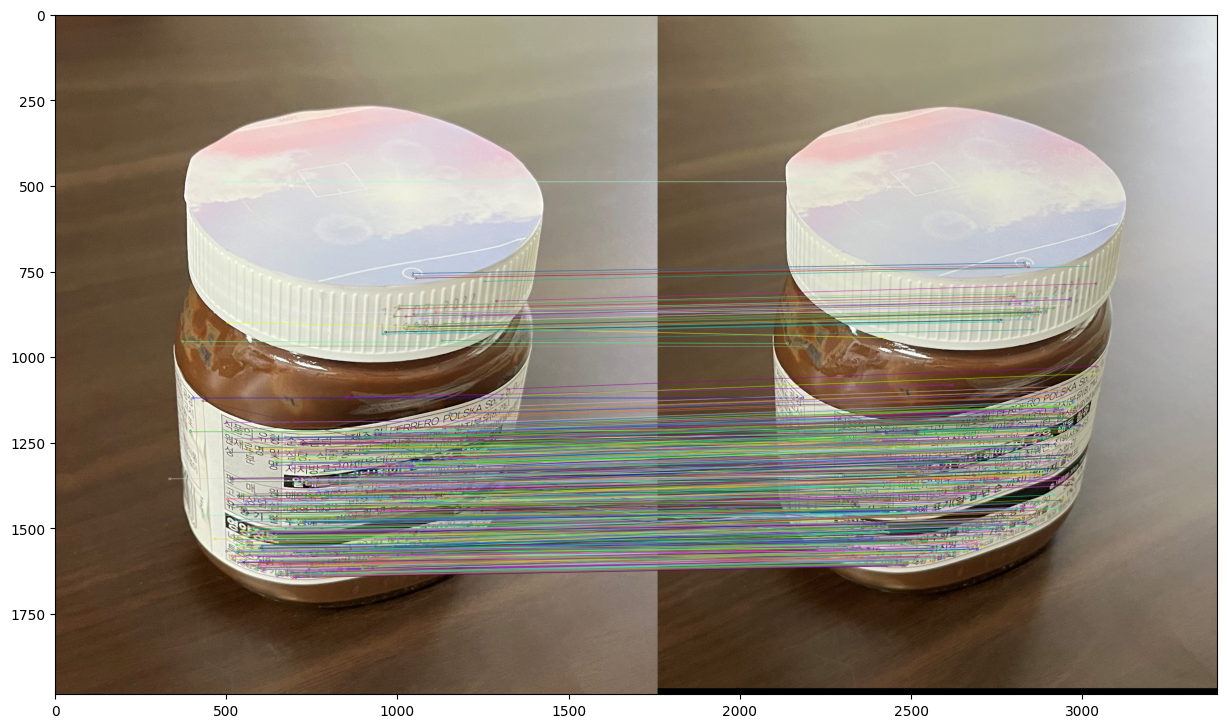

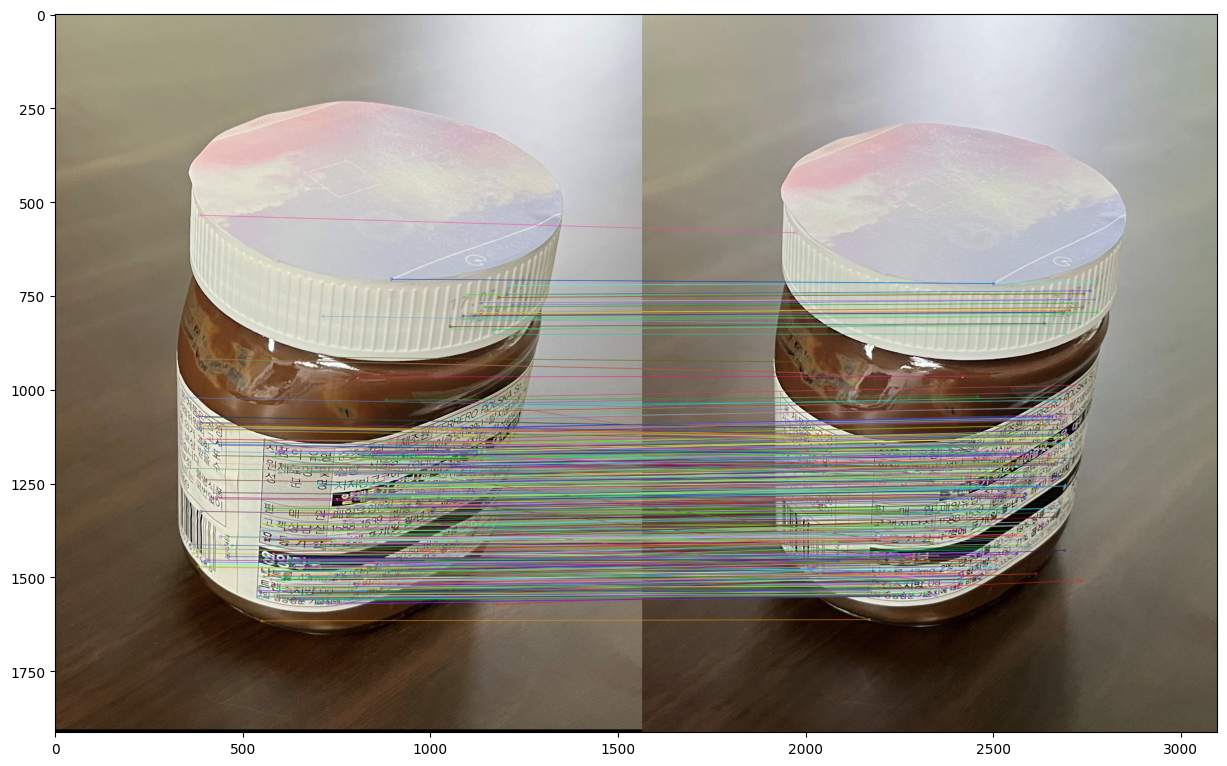

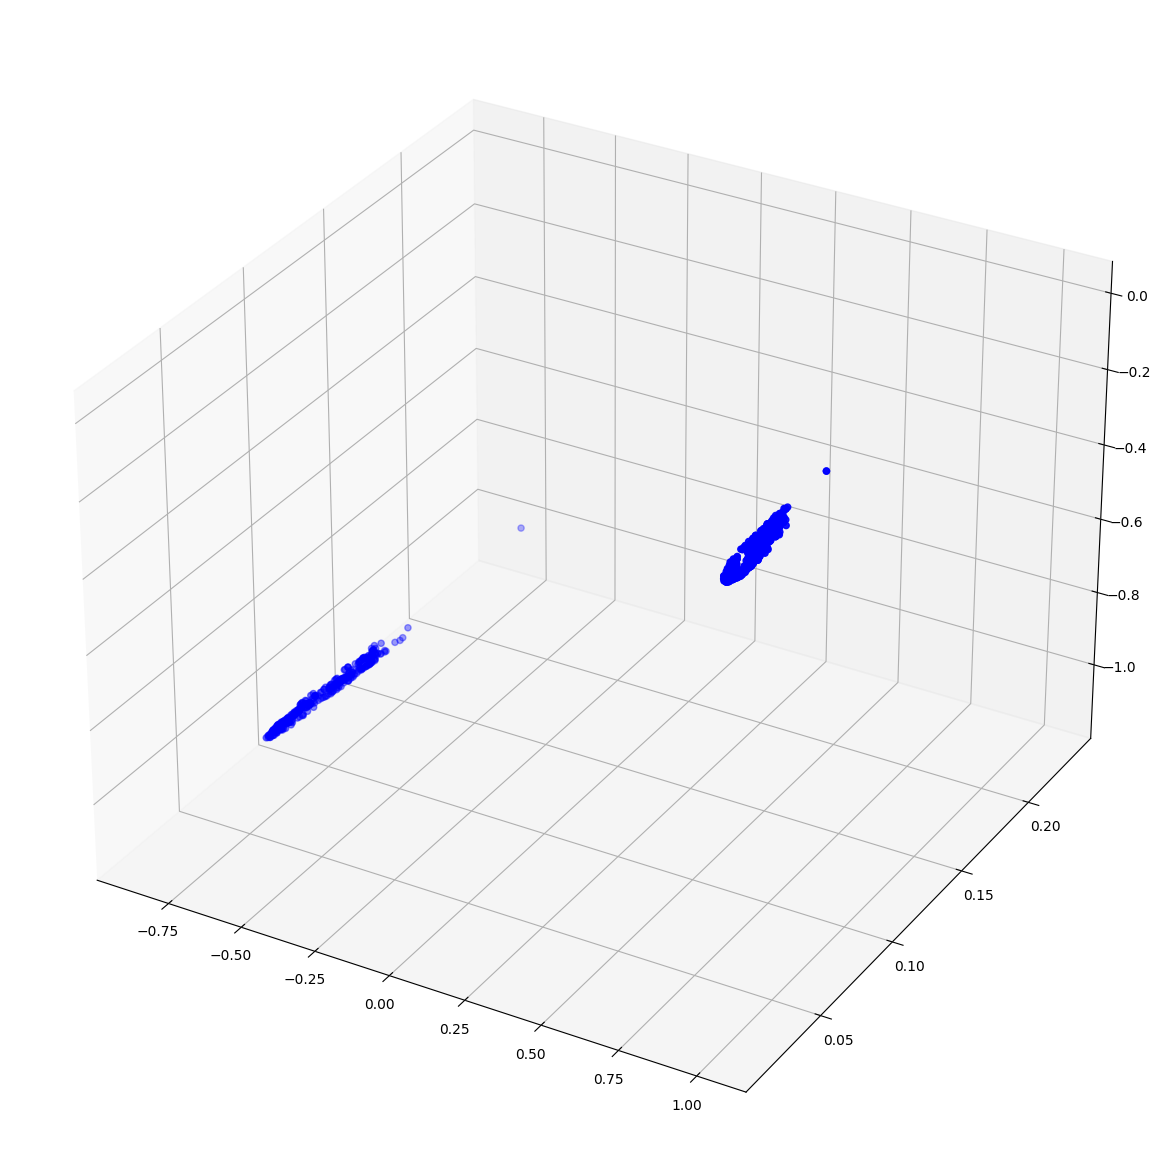

In [4]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img_path = 'C:/Users/hyune/Documents/SFM/sfm/data/nutellar2/'

img1_name = 'nutella25.jpg'
img2_name = 'nutella26.jpg'
img3_name = 'nutella27.jpg'
img4_name = 'nutella28.jpg'

# 이미지 로드 함수
def load_image(img_path, img1_name, img2_name):
    img1 = cv2.imread(img_path + img1_name)
    img2 = cv2.imread(img_path + img2_name)
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    return img1, img2

# 특징점 추출 및 매칭 (SIFT 사용)
def SIFT(img1, img2):
    sift = cv2.SIFT_create()
    img1_kp, img1_des = sift.detectAndCompute(img1, None)
    img2_kp, img2_des = sift.detectAndCompute(img2, None)

    bf = cv2.BFMatcher()
    matches = bf.knnMatch(img1_des, img2_des, k=2)
    matches_good = [m1 for m1, m2 in matches if m1.distance < 0.55 * m2.distance]

    sorted_matches = sorted(matches_good, key=lambda x: x.distance)
    res = cv2.drawMatches(img1, img1_kp, img2, img2_kp, sorted_matches, img2, flags=2)
    
    plt.figure(figsize=(15, 15))
    plt.imshow(res)
    plt.show()
    return matches_good, img1_kp, img2_kp

# 에센셜 매트릭스 추정
def Estimation_E(matches_good, img1_kp, img2_kp):
    query_idx = [match.queryIdx for match in matches_good]
    train_idx = [match.trainIdx for match in matches_good]
    p1 = np.float32([img1_kp[ind].pt for ind in query_idx]) 
    p2 = np.float32([img2_kp[ind].pt for ind in train_idx])

    E, mask = cv2.findEssentialMat(p1, p2, method=cv2.RANSAC, focal=3092.8, pp=(2016, 1512), maxIters=1000, threshold=0.3)
    
    p1 = p1[mask.ravel() == 1]
    p2 = p2[mask.ravel() == 1]

    return E, p1, p2

# 에센셜 매트릭스 분해
def EM_Decomposition(E, p1, p2):
    U, S, VT = np.linalg.svd(E, full_matrices=True)
    W = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])

    camera_matrix = np.array([
        np.column_stack((U @ W @ VT, U[:, 2])),
        np.column_stack((U @ W @ VT, -U[:, 2])),
        np.column_stack((U @ W.T @ VT, U[:, 2])),
        np.column_stack((U @ W.T @ VT, -U[:, 2]))
    ])

    return camera_matrix[0]  # 첫 번째 카메라 행렬 선택

# 내부 카메라 행렬 초기화
def initialize_CM(CameraMatrix):
    Rt0 = np.hstack((np.eye(3), np.zeros((3, 1))))
    skew = 0.0215878
    K = np.array([[3092.8, skew, 2016], [0, 3092.8, 1512], [0, 0, 1]])
    Rt1 = K @ CameraMatrix
    return Rt0, Rt1

# 삼각측량
def LinearTriangulation(Rt0, Rt1, p1, p2):
    A = np.array([
        p1[1] * Rt0[2, :] - Rt0[1, :],
        -(p1[0] * Rt0[2, :] - Rt0[0, :]),
        p2[1] * Rt1[2, :] - Rt1[1, :],
        -(p2[0] * Rt1[2, :] - Rt1[0, :])
    ])
    
    A = A.reshape((4, 4))
    AA = A.T @ A
    U, S, VT = np.linalg.svd(AA)

    return VT[3, 0:3] / VT[3, 3]

# 3D 포인트 생성
def make_3dpoint(p1, p2, Rt0, Rt1):
    p3ds = []
    for pt1, pt2 in zip(p1, p2):
        p3d = LinearTriangulation(Rt0, Rt1, pt1, pt2)
        p3ds.append(p3d)
    return np.array(p3ds).T

# 3D 시각화
def visualize_3d(p3ds):
    X = p3ds[0]
    Y = p3ds[1]
    Z = p3ds[2]

    fig = plt.figure(figsize=(15, 15))
    ax = plt.axes(projection='3d')
    ax.scatter3D(X, Y, Z, c='b', marker='o') 
    plt.show()

# 두 번째 2-view의 좌표계를 첫 번째 2-view에 맞추기 위한 변환
def align_coordinate_system(Rt1_first, Rt1_second):
    # 두 번째 카메라의 좌표계를 첫 번째 카메라 좌표계에 맞추기 위한 변환 행렬
    T = np.linalg.inv(Rt1_first[:, :3]) @ Rt1_second[:, :3]
    return T

# 2-view 재구성
def reconstruct_2view(img1_name, img2_name):
    img1, img2 = load_image(img_path, img1_name, img2_name)
    matches_good, img1_kp, img2_kp = SIFT(img1, img2)
    E, p1_inlier, p2_inlier = Estimation_E(matches_good, img1_kp, img2_kp)
    CameraMatrix = EM_Decomposition(E, p1_inlier, p2_inlier)
    Rt0, Rt1 = initialize_CM(CameraMatrix)
    point3d = make_3dpoint(p1_inlier, p2_inlier, Rt0, Rt1)
    return point3d, Rt1

# 2-view 두 개를 결합하여 4-view 처리
def reconstruct_4view():
    # 첫 번째 2-view 재구성
    p3ds_12, Rt1_first = reconstruct_2view(img1_name, img2_name)
    
    # 두 번째 2-view 재구성
    p3ds_34, Rt1_second = reconstruct_2view(img3_name, img4_name)
    
    # 두 번째 2-view의 좌표계를 첫 번째 2-view의 좌표계에 맞추는 변환 행렬 적용
    T = align_coordinate_system(Rt1_first, Rt1_second)
    p3ds_34_transformed = T @ p3ds_34
    
    # 두 세트의 3D 포인트를 결합
    p3ds_combined = np.hstack((p3ds_12, p3ds_34_transformed))

    visualize_3d(p3ds_combined)

# 4-view 재구성 실행
reconstruct_4view()
